In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
from itertools import product
from random import sample
from sklearn.preprocessing import normalize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Image Processing/lez11_Inpainting_and_Spark')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Image Processing/lez11_Inpainting_and_Spark'

Useful function for plot the 2D DCT dictionary

In [4]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [5]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x = np.zeros(N)
  r = s # residual
  omega = [] # support set

  while np.count_nonzero(x) < L and np.linalg.norm(r, ord=2) > tau:

      # SWEEP STEP: look for the column of D that matches at best noisySignal
      # compute the residual w.r.t. each column of D
      e = np.zeros(N)
      for j in range(N):
          dj = D[:,j].copy()
          e[j] = (np.linalg.norm(r, ord=2)**2) - (np.dot(np.transpose(r), dj)**2) / (np.linalg.norm(dj, ord=2)**2)

      # find the column of D that matches at best r
      jStar = np.argmin(e)

      # UPDATE the support set with the jStar coefficient
      omega.append(jStar)

      # update the coefficients by solving the least square problem min ||D_omega x - s ||
      x = np.zeros(N)
      x[omega] = np.linalg.solve(np.dot(np.transpose(D[:,omega]),D[:,omega]), np.dot(np.transpose(D[:,omega]), s))

      # update the residual 
      r = s - np.dot(D,x)
  
  return x

Load the image and rescale it in $[0,1]$

In [6]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = imread(f'./data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2

Extract a bunch of random patches from the image

In [7]:
npatch = 10000 #10000

S = np.zeros((M, npatch))
random_coord_patches = sample(list(product(range(imsz[0] - p + 1), repeat=2)), k=npatch) # repeat=2->tuple
count = 0
for x,y in random_coord_patches:
  S[:,count] = img[x:x+p,y:y+p].flatten()
  count += 1

Remove the mean from the patches (each column of $S$ must have zero-mean)

In [8]:
for i in range(npatch):
  S[:,i] = S[:,i] - S[:,i].mean()

Initialize the dictionary and the coefficient matrix

In [9]:
# number of columns of the dictionary
N = 256

# intialize the dictionary
D = np.random.random((M, N))

# normalize each column of D (zero mean and unit norm)
for i in range(N):
  D[:,i] = D[:,i] - D[:,i].mean()
D = normalize(D, axis=0, norm='l2')

# number of iteration of the KSVD
max_iter = 10

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))

Main KSVD loop


In [10]:
for iter in range(max_iter):
    time_start = time.time()
    print(f'iter {iter}')
    # perform the sparse coding via OMP of all the columns of S
    for n in range(npatch):
        X[:, n] = OMP(S[:,n],D,L,0)
    
    # iterate over the columns of D
    for j in range(N):
        # find which signals uses the j-th atom in the sparse coding
        omega = np.nonzero(X[j,:])[0]

        if len(omega) == 0:
            # if the atom is never used then ignore or substitute it with a random vector
            D[:,j] = np.random.random(M)
            # normalize each column of D (zero mean and unit norm)
            D[:,j] = D[:,j] - D[:,j].mean()
            D = normalize(D, axis=0, norm='l2')
        else:
            # compute the residual matrix E, ignoring the j-th atom
            E = S 
            for col in range(N):
              if col != j:
                E = E - np.dot(D[:,col].reshape((M,1)),X[col,:].reshape((1,npatch)))

            # restrict E to the columns indicated by omega
            Eomega = E[:,omega]

            # compute the SVD of Eomega
            U, Sigma, V = np.linalg.svd(Eomega, full_matrices=False)

            # update the dictionary
            D[:,j] = U[:,0]

            # update the coefficient matrix
            X[j,omega] = Sigma[0] * V[0,:]
    
    time_end = time.time()
    print(f'{time_end - time_start:.0f}')


iter 0
384
iter 1
384
iter 2
387
iter 3
385
iter 4
383
iter 5
381
iter 6
384
iter 7
376
iter 8
380
iter 9
381


Show the learned dictionary

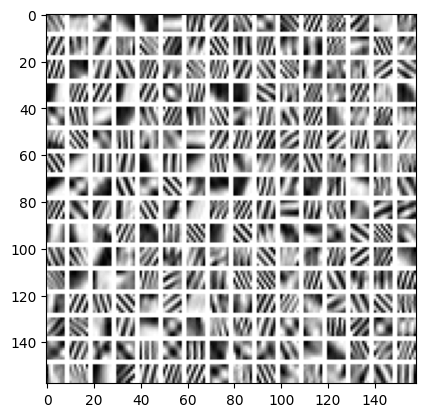

In [11]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray')
